In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import cufflinks as cf  
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
cf.go_offline()

ModuleNotFoundError: No module named 'cufflinks'

In [2]:
# Įsikeliame duomenis
liver_patient = pd.read_csv("duomenys/Indian_Liver_Patient.csv")
liver_patient.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [3]:
# Pervadiname stulpelį dataset į liver_disease

liver_patient.rename(columns={'Dataset': 'Liver_Disease'}, inplace=True)
liver_patient['Gender'] = liver_patient['Gender'].apply(lambda x: 1 if x =='Male' else 0)
#Female=0 and Male = 1

# Užpildome praleistas reikšmes vidurkiu 
liver_patient['Albumin_and_Globulin_Ratio'].mean()
liver_patient=liver_patient.fillna(0.94)

In [339]:
liver_patient.groupby('Liver_Disease').size() # Pasižiūrime, kiek kiekvienoje grupėje yra stebėjimų
# Gauname, kad sergančių yra 416, o nesergančių 167 

Liver_Disease
1    416
2    167
dtype: int64

In [340]:
columns = liver_patient.columns # Pasižiūrime visų stulpelių pavadinimus.

In [341]:
# Pasidarome X ir Y, kurį prognozuosime
X = liver_patient[['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio']]
y = liver_patient['Liver_Disease']

# Standartizuojame duomenis
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [342]:
# Pasidarome test ir train rinkinius

Xtrain, Xtest, ytrain, ytest = train_test_split( 
        X, y, test_size = 0.3, random_state = 0)


PIRMAS MODELIS (su visais kintamaisiais)

In [345]:
# Modelio kūrimas
model = LogisticRegression(class_weight = {1:1,2:2})

model.fit(Xtrain, ytrain)
pred = model.predict(Xtest)
prob = model.predict_proba(Xtest)

C:\Users\nasev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [346]:
print('Log-loss = {0:.02f}'.format(
    log_loss(ytest, prob)))
print('Hit rate = {0:.02%}'.format(
    (ytest == pred).mean()))

Log-loss = 0.55
Hit rate = 68.00%


In [295]:
#Suskaičiuojame Confusion matricą
pd.DataFrame(confusion_matrix(ytest, pred),
             columns = model.classes_, index = model.classes_)
# Gauname, kad iš pirmos grupės į pirmą modelis klasifikuoja 83 stebėjimus, o į antrą 39.
# Iš antros grupės į pirmą klasifikuoja tik 17 pacientus, o į antrą 36.  

,1,2
1,83,39
2,17,36


In [296]:
# Atspausdiname klasifikavimo ataskaitą
print(classification_report(ytest, pred))
# Lentelėje matome Precision, Recall ir F1 - score rodiklius

              precision    recall  f1-score   support

           1       0.83      0.68      0.75       122
           2       0.48      0.68      0.56        53

    accuracy                           0.68       175
   macro avg       0.66      0.68      0.66       175
weighted avg       0.72      0.68      0.69       175



In [297]:
# Atspausdiname kintamųjų reiškmingumą
feature_importance = pd.DataFrame(np.hstack((np.array([columns[0:-1]]).T, model.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False)
# Iš gautos lentelės matome, kad reikšmingiausias kintamasis yra Alamine_Aminotransferase, 
# o mažiausiai reikšmingas yra Gender

,feature,importance
8,Albumin,0.825765
1,Gender,-0.033641
4,Alkaline_Phosphotase,-0.118199
2,Total_Bilirubin,-0.158883
9,Albumin_and_Globulin_Ratio,-0.170717
0,Age,-0.356224
3,Direct_Bilirubin,-0.749232
7,Total_Protiens,-0.800518
6,Aspartate_Aminotransferase,-1.151424
5,Alamine_Aminotransferase,-1.351380


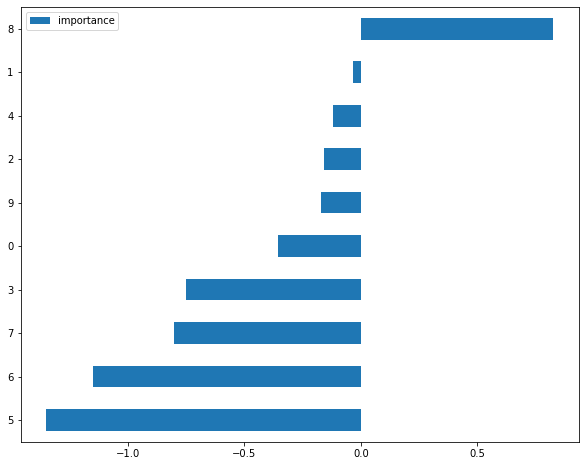

In [298]:
# Nubraižome grafiką, kuriame vizualiai matosi, kurie kintamieji reikšmingiausi, ir kurie mažiau reiškmingi  
feature_importance = pd.DataFrame(np.hstack((np.array([columns[0:-1]]).T, model.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by = ["importance"]).plot(kind='barh', figsize=(10,8))

ANTRAS MODELIS 
(Pridėjus naujus stulpelius)


In [330]:
# Apskaičiuojame kelis naujus kintamuosius, kurie galbūt pagerins modelį
#Apsiskaiciuojame Globulina
liver_patient['Globulin'] = liver_patient['Albumin'] / liver_patient['Albumin_and_Globulin_Ratio']

#Susiskaiciuojam netiesiogini bilirubina (nekonjuguotas) (jis lygus is bendro atemus tiesiogini)
liver_patient['Indirect_Bilirubin'] = liver_patient['Total_Bilirubin'] - liver_patient['Direct_Bilirubin']
liver_patient['Protiens_Ratio'] = liver_patient['Total_Protiens'] / liver_patient['Albumin']

liver_patient.head()


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Disease,Globulin,Indirect_Bilirubin,Protiens_Ratio
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,3.666667,0.6,2.060606
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,4.324324,5.4,2.343750
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3.707865,3.2,2.121212
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,3.400000,0.6,2.000000
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,6.000000,1.9,3.041667


In [331]:
columns2 = liver_patient.columns

X = liver_patient[['Age', 'Gender', 'Total_Bilirubin', 'Direct_Bilirubin',
       'Alkaline_Phosphotase', 'Alamine_Aminotransferase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
       'Albumin_and_Globulin_Ratio', 'Globulin',
       'Indirect_Bilirubin', 'Protiens_Ratio']]
y = liver_patient['Liver_Disease']

scaler = StandardScaler()
X = scaler.fit_transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split( 
        X, y, test_size = 0.3, random_state = 0)


In [334]:
model2 = LogisticRegression(class_weight = {1:1,2:2})

model2.fit(Xtrain, ytrain)
pred2 = model2.predict(Xtest)
prob2 = model2.predict_proba(Xtest)

print('Log-loss = {0:.02f}'.format(
    log_loss(ytest, prob2)))
print('Hit rate = {0:.02%}'.format(
    (ytest == pred2).mean()))

# Pridėjus naujų kintamūjų Hit rate rodiklis šiek tiek sumažėja

Log-loss = 0.55
Hit rate = 66.86%


C:\Users\nasev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [335]:
# suskaičiuojame Confusion matrix
pd.DataFrame(confusion_matrix(ytest, pred2),
             columns=model2.classes_, index=model2.classes_)
# Taip pat šiek tiek pablogėja klasifikavimas. Pablogėjo antros grupės (nesergančių) klasifikavimas

,1,2
1,83,39
2,19,34


In [304]:
print(classification_report(ytest, pred2))

              precision    recall  f1-score   support

           1       0.81      0.68      0.74       122
           2       0.47      0.64      0.54        53

    accuracy                           0.67       175
   macro avg       0.64      0.66      0.64       175
weighted avg       0.71      0.67      0.68       175



In [305]:
feature_importance = pd.DataFrame(np.hstack((np.array([columns2[0:-1]]).T, model2.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
8,Albumin,1.055902
12,Indirect_Bilirubin,0.218858
11,Globulin,0.093607
1,Gender,-0.034776
10,Liver_Disease,-0.117267
4,Alkaline_Phosphotase,-0.124798
9,Albumin_and_Globulin_Ratio,-0.216628
2,Total_Bilirubin,-0.266869
0,Age,-0.359073
3,Direct_Bilirubin,-0.723110


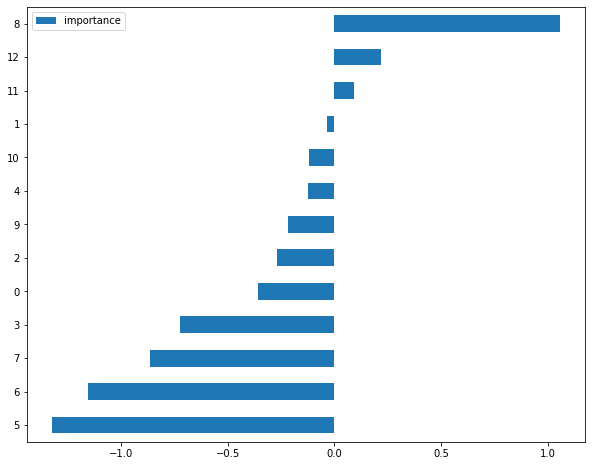

In [306]:
feature_importance = pd.DataFrame(np.hstack((np.array([columns2[0:-1]]).T, model2.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by = ["importance"]).plot(kind='barh', figsize=(10,8))

TREČIAS MODELIS (išmetus stulpelius, kurie stipriai koreliuoja su kitais)

In [307]:
# Išmetame kintamuosius, kurie stipriai koreliuoja su kitais
liver_patient = liver_patient.drop(['Direct_Bilirubin','Alamine_Aminotransferase','Albumin_and_Globulin_Ratio'],axis=1)
liver_patient.head()

,Age,Gender,Total_Bilirubin,Alkaline_Phosphotase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Liver_Disease,Globulin,Indirect_Bilirubin,Protiens_Ratio
0,65,0,0.7,187,18,6.8,3.3,1,3.666667,0.6,2.060606
1,62,1,10.9,699,100,7.5,3.2,1,4.324324,5.4,2.343750
2,62,1,7.3,490,68,7.0,3.3,1,3.707865,3.2,2.121212
3,58,1,1.0,182,20,6.8,3.4,1,3.400000,0.6,2.000000
4,72,1,3.9,195,59,7.3,2.4,1,6.000000,1.9,3.041667


In [308]:
columns3 = liver_patient.columns

X = liver_patient[['Age', 'Gender', 'Total_Bilirubin', 'Alkaline_Phosphotase',
       'Aspartate_Aminotransferase', 'Total_Protiens', 'Albumin',
    'Globulin', 'Indirect_Bilirubin', 'Protiens_Ratio']]
y = liver_patient['Liver_Disease']

scaler = StandardScaler()
X = scaler.fit_transform(X)

Xtrain, Xtest, ytrain, ytest = train_test_split( 
        X, y, test_size = 0.3, random_state = 0)

In [310]:
model3 = LogisticRegression(class_weight = {1:1,2:2})

model3.fit(Xtrain, ytrain)
pred3 = model3.predict(Xtest)
prob3 = model3.predict_proba(Xtest)

print('Log-loss = {0:.02f}'.format(
    log_loss(ytest, prob3)))
print('Hit rate = {0:.02%}'.format(
    (ytest == pred3).mean()))
# Hit rate pakilo iki 67,43%

Log-loss = 0.56
Hit rate = 67.43%


C:\Users\nasev\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



In [313]:
# suskaičiuojame Cofusion matrix
pd.DataFrame(confusion_matrix(ytest, pred3),
             columns = model3.classes_, index = model3.classes_)
# Išmetus koreliuotus kintamuosius pirmos grupės klasifikavimas šiek tiek pagerėjo, o antros pablogėjo

,1,2
1,86,36
2,21,32


In [314]:
print(classification_report(ytest, pred3))

              precision    recall  f1-score   support

           1       0.80      0.70      0.75       122
           2       0.47      0.60      0.53        53

    accuracy                           0.67       175
   macro avg       0.64      0.65      0.64       175
weighted avg       0.70      0.67      0.68       175



In [315]:
feature_importance = pd.DataFrame(np.hstack((np.array([columns3[0:-1]]).T, model3.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
6,Albumin,0.895609
8,Globulin,0.296109
9,Indirect_Bilirubin,0.259883
7,Liver_Disease,-0.005295
1,Gender,-0.047580
3,Alkaline_Phosphotase,-0.183636
0,Age,-0.353924
5,Total_Protiens,-0.863057
2,Total_Bilirubin,-1.177128
4,Aspartate_Aminotransferase,-2.035840


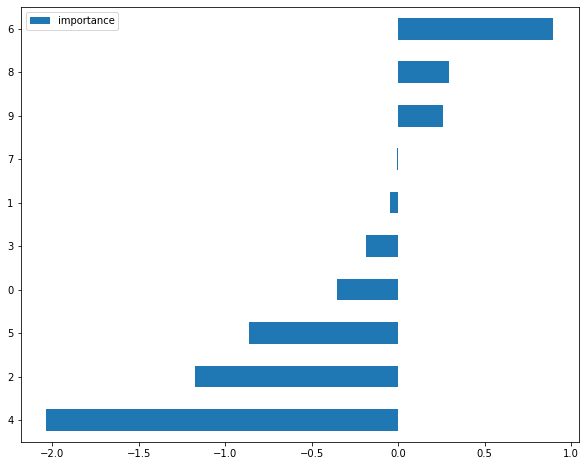

In [316]:
feature_importance = pd.DataFrame(np.hstack((np.array([columns3[0:-1]]).T, model3.coef_.T)),
                                  columns=['feature', 'importance'])
feature_importance['importance'] = pd.to_numeric(feature_importance['importance'])
feature_importance.sort_values(by = ["importance"]).plot(kind='barh', figsize=(10,8))